<a href="https://colab.research.google.com/github/Zuzed22/Challenge-Telecom-X-an-lisis-de-evasi-n-de-clientes/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [1]:
import pandas as pd
import numpy as np


url = "https://github.com/alura-cursos/challenge2-data-science-LATAM/raw/main/TelecomX_Data.json"
df_raw = pd.read_json(url)

#### Normalización y aplanamiento del JSON

In [2]:
def flatten_df(df, sep="_"):
    df = df.copy()


    list_cols = [c for c in df.columns
                 if df[c].apply(lambda x: isinstance(x, list)).any()]
    for col in list_cols:
        df = df.explode(col, ignore_index=True)


    while True:
        dict_cols = [c for c in df.columns
                     if df[c].apply(lambda x: isinstance(x, dict)).any()]
        if not dict_cols:
            break

        for col in dict_cols:
            norm = (
                pd.json_normalize(df[col])
                  .add_prefix(f"{col}{sep}"))
            df = pd.concat(
                [df.drop(columns=[col]).reset_index(drop=True),
                 norm.reset_index(drop=True)],
                axis=1)
    return df

#🔧 Transformación

#### Limpieza y transformación

In [3]:
df_flat = flatten_df(df_raw)


df_flat['account_Charges.Total'] = (
    df_flat['account_Charges.Total']
        .replace(r'^\s*$', np.nan, regex=True)
        .astype(float))

In [4]:
rename_cols = {
    'index': 'Indice',
    'customerID': 'Id_cliente',
    'Churn': 'Churn',
    'customer_gender': 'Genero_cliente',
    'customer_SeniorCitizen': 'Cliente_senior',
    'customer_Partner': 'Cliente_partner',
    'customer_Dependents': 'Cliente_dependiente',
    'customer_tenure': 'Antiguedad_cliente',
    'phone_PhoneService': 'Servicio_telefono',
    'phone_MultipleLines': 'Multiples_lineas',
    'internet_InternetService': 'Servicio_internet',
    'internet_OnlineSecurity': 'Seguridad_online',
    'internet_OnlineBackup': 'Respaldo_online',
    'internet_DeviceProtection': 'Proteccion_dispositivos',
    'internet_TechSupport': 'Soporte_tecnico',
    'internet_StreamingTV': 'Streaming',
    'internet_StreamingMovies': 'Peliculas_streaming',
    'account_Contract': 'Contrato',
    'account_PaperlessBilling': 'Boleta_electronica',
    'account_PaymentMethod': 'Metodo_pago',
    'account_Charges.Monthly': 'Cargo_mensual',
    'account_Charges.Total': 'Cargo_total'}

#### Codificación de la variable objetivo

In [5]:
df_flat.rename(columns=rename_cols, inplace=True)
if 'Indice' in df_flat.columns:

    df_flat.set_index('Indice', inplace=True, drop=True)

df_flat.to_parquet("telecomx_flat_renombrado.parquet", index=False)
churn_total = df_flat['Churn'].sum()
df_flat['Churn'] = df_flat['Churn'].map({'Yes': 1, 'No': 0})

churn_total = df_flat['Churn'].sum()
churn_total_porcentaje = (churn_total / len(df_flat)) * 100

df_flat.head()

,Id_cliente,Churn,Genero_cliente,Cliente_senior,Cliente_partner,Cliente_dependiente,Antiguedad_cliente,Servicio_telefono,Multiples_lineas,Servicio_internet,...,Respaldo_online,Proteccion_dispositivos,Soporte_tecnico,Streaming,Peliculas_streaming,Contrato,Boleta_electronica,Metodo_pago,Cargo_mensual,Cargo_total
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,1.0,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,1.0,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,1.0,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


#📊 Carga y análisis

#### Análisis descriptivo básico

In [6]:
df_no_churn = df_flat[df_flat['Churn'] == 0]
df_churn = df_flat[df_flat['Churn'] == 1]
no_churn_total = len(df_no_churn)
no_churn_pct   = no_churn_total / len(df_flat) * 100

nulos_churn = df_flat['Churn'].isna().sum()

df_clean = df_flat.dropna(subset=['Churn'])

total_clean = len(df_clean)
activos_pct = (df_clean['Churn'] == 0).sum() / total_clean * 100
cancelados_pct = (df_clean['Churn'] == 1).sum() / total_clean * 100

print(f"Filas tras limpieza: {total_clean}")
print(f"Activos:    {activos_pct:.2f}%")
print(f"Cancelados: {cancelados_pct:.2f}%")
print(f"Suma total: {(activos_pct + cancelados_pct):.2f}%")

df_no_churn.head()

Filas tras limpieza: 7043
Activos:    73.46%
Cancelados: 26.54%
Suma total: 100.00%


,Id_cliente,Churn,Genero_cliente,Cliente_senior,Cliente_partner,Cliente_dependiente,Antiguedad_cliente,Servicio_telefono,Multiples_lineas,Servicio_internet,...,Respaldo_online,Proteccion_dispositivos,Soporte_tecnico,Streaming,Peliculas_streaming,Contrato,Boleta_electronica,Metodo_pago,Cargo_mensual,Cargo_total
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.30
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.40
5,0013-MHZWF,0.0,Female,0,No,Yes,9,Yes,No,DSL,...,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),69.40,571.45
6,0013-SMEOE,0.0,Female,1,Yes,No,71,Yes,No,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.70,7904.25
7,0014-BMAQU,0.0,Male,0,Yes,No,63,Yes,Yes,Fiber optic,...,No,No,Yes,No,No,Two year,Yes,Credit card (automatic),84.65,5377.80


#### Análisis Exploratorio (EDA)

- Comparativa entre hombres y mujeres.
- Distribución entre clientes que cancelaron (churn) y no cancelaron.
- Separación entre clientes adultos mayores (1) y no seniors (0).
- Claramente útil para detectar si los clientes mayores tienden más al churn.
- Clientes agrupados por su tiempo de permanencia.
- Evaluación de lealtad/fidelidad frente al churn.

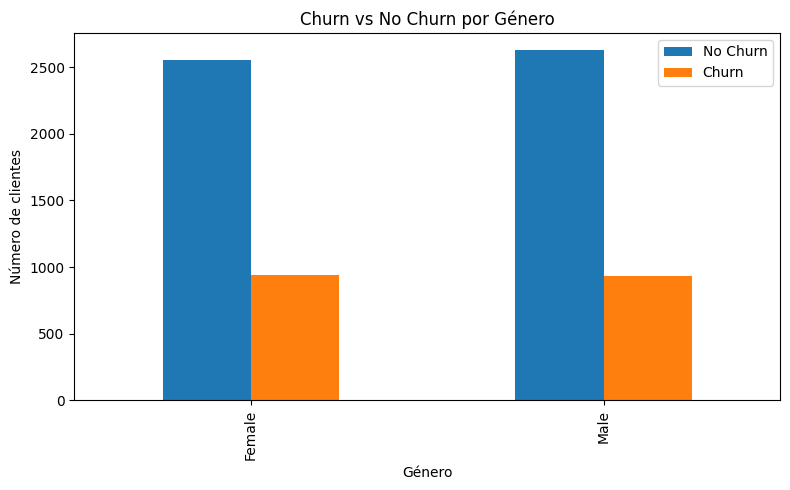

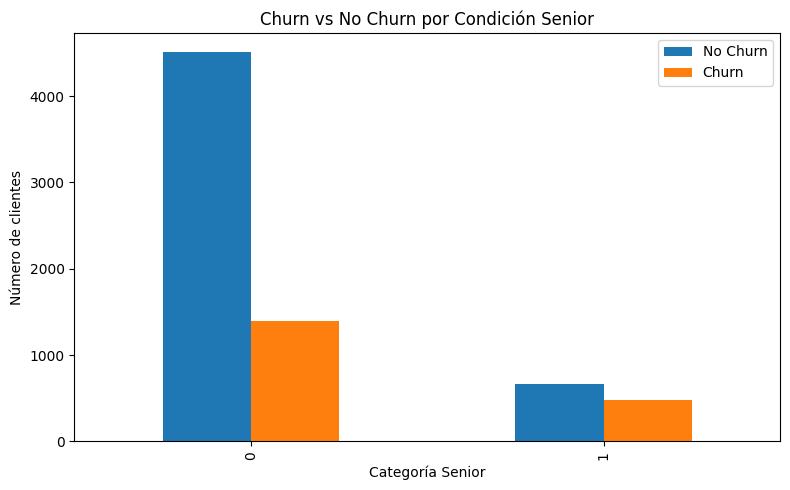

In [7]:
import matplotlib.pyplot as plt

#  Gráfico por género
gender_counts = df_clean.groupby(['Genero_cliente', 'Churn']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Género')
plt.xlabel('Género')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

#  Gráfico Senior
senior_counts = df_clean.groupby(['Cliente_senior', 'Churn']).size().unstack(fill_value=0)
senior_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Condición Senior')
plt.xlabel('Categoría Senior')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()


df_tmp = df_clean.copy()
bins   = [0, 12, 24, 48, df_tmp['Antiguedad_cliente'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'Categoria_fidelidad'] = pd.cut(
    df_tmp['Antiguedad_cliente'],
    bins=bins, labels=labels, right=False)

In [8]:
# Tabla de frecuencias (stacked) — indicamos observed para silenciar el aviso
fid_counts = (
    df_tmp
      .groupby(['Categoria_fidelidad', 'Churn'], observed=True)
      .size()
      .unstack(fill_value=0))

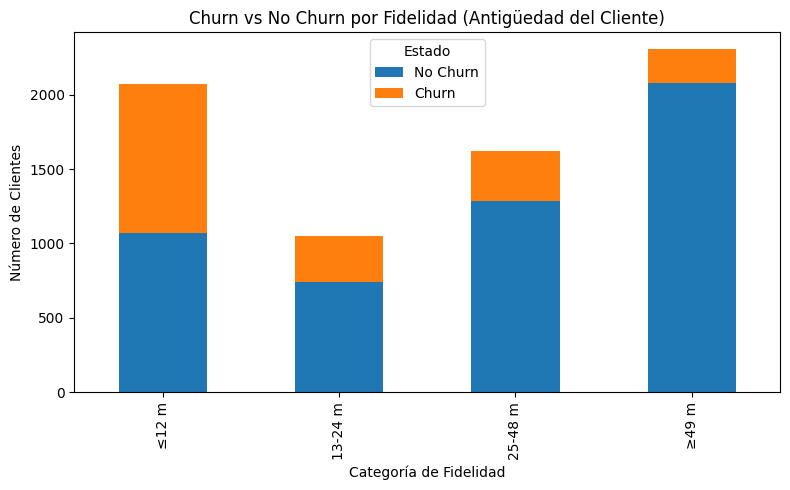

In [9]:
# Gráfico
fid_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Churn vs No Churn por Fidelidad (Antigüedad del Cliente)')
plt.xlabel('Categoría de Fidelidad')
plt.ylabel('Número de Clientes')
plt.legend(['No Churn', 'Churn'], title='Estado')
plt.tight_layout()
plt.show()

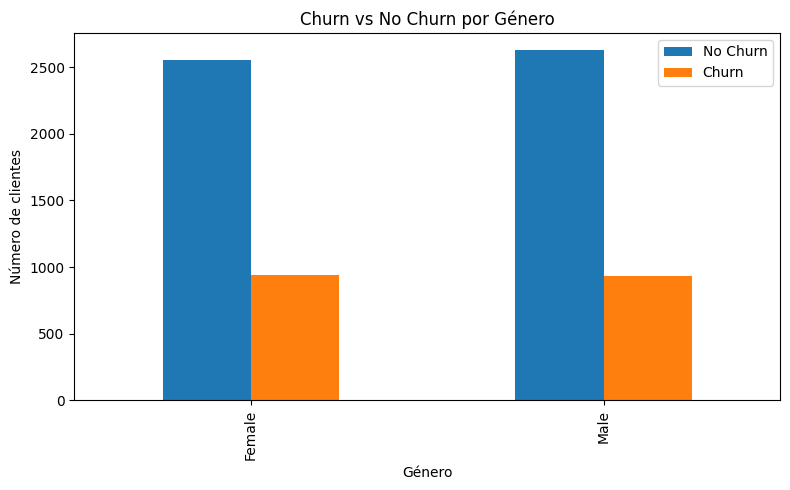

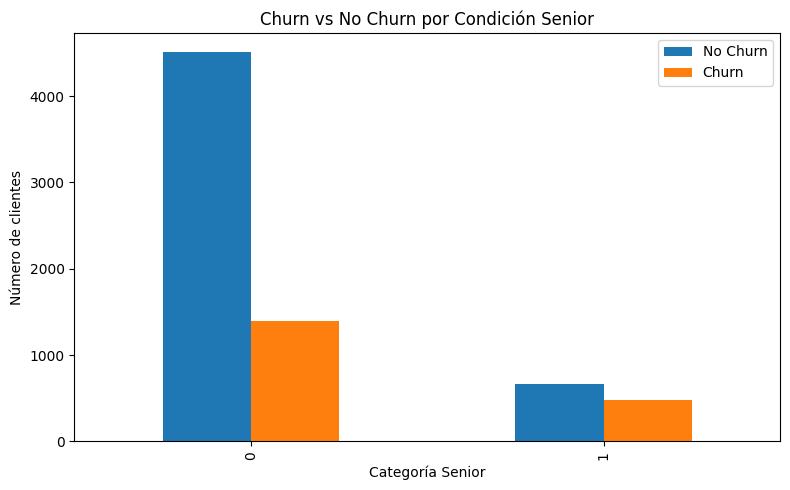

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

#  Gráfico por Género
gender_counts = df_clean.groupby(['Genero_cliente', 'Churn']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Género')
plt.xlabel('Género')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

#  Gráfico por Senior
senior_counts = df_clean.groupby(['Cliente_senior', 'Churn']).size().unstack(fill_value=0)
senior_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Condición Senior')
plt.xlabel('Categoría Senior')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

In [11]:
df_tmp = df_clean.copy()
bins   = [0, 12, 24, 48, df_tmp['Antiguedad_cliente'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'Categoria_fidelidad'] = pd.cut(
    df_tmp['Antiguedad_cliente'],
    bins=bins, labels=labels, right=False)

In [12]:
# Tabla de frecuencias (stacked) — indicamos observed para silenciar el aviso
fid_counts = (
    df_tmp
      .groupby(['Categoria_fidelidad', 'Churn'], observed=True)
      .size()
      .unstack(fill_value=0))

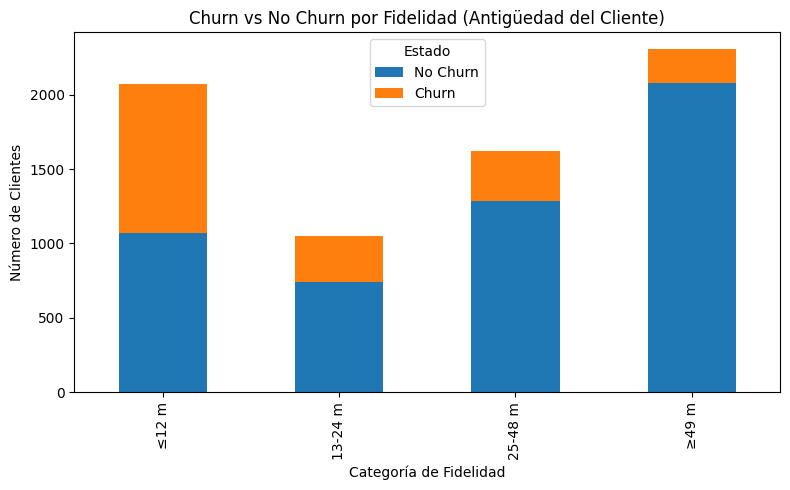

                     total  fugitivos  pct_churn
Categoria_fidelidad                             
≤12 m                 2069      999.0  48.284195
13-24 m               1047      309.0  29.512894
25-48 m               1624      339.0  20.874384
≥49 m                 2303      222.0   9.639601


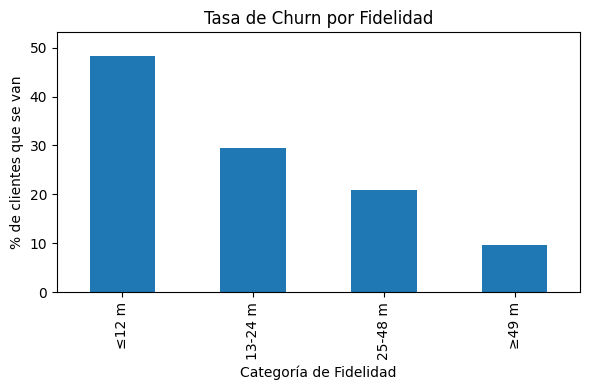

In [13]:
# Gráfico
fid_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Churn vs No Churn por Fidelidad (Antigüedad del Cliente)')
plt.xlabel('Categoría de Fidelidad')
plt.ylabel('Número de Clientes')
plt.legend(['No Churn', 'Churn'], title='Estado')
plt.tight_layout()
plt.show()

tasa_churn = (
    df_tmp
      .groupby('Categoria_fidelidad', observed=True)['Churn']
      .agg(total='size', # Changed from ('Churn', 'size') to 'size'
           fugitivos='sum') # Changed from ('Churn', 'sum') to 'sum'
      .assign(pct_churn=lambda x: x['fugitivos'] / x['total']*100))

print(tasa_churn[['total', 'fugitivos', 'pct_churn']])

tasa_churn['pct_churn'].plot(kind='bar', figsize=(6,4))
plt.title('Tasa de Churn por Fidelidad')
plt.ylabel('% de clientes que se van')
plt.xlabel('Categoría de Fidelidad')
plt.ylim(0, tasa_churn['pct_churn'].max() * 1.1)
plt.tight_layout()
plt.show()

                     total  fugitivos  pct_churn
Categoria_fidelidad                             
≤12 m                 2069      999.0  48.284195
13-24 m               1047      309.0  29.512894
25-48 m               1624      339.0  20.874384
≥49 m                 2303      222.0   9.639601


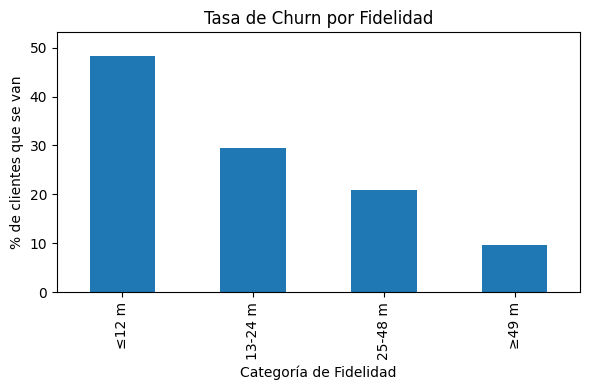


----- Servicio_internet -----
Churn              Churn  No Churn  Pct_Churn
Servicio_internet                            
DSL                  459      1962  18.959108
Fiber optic         1297      1799  41.892765
No                   113      1413   7.404980


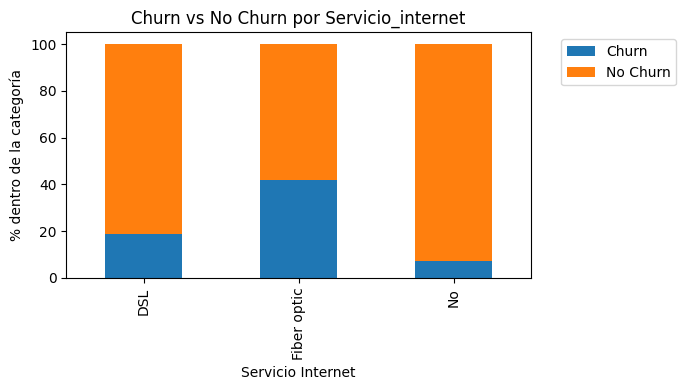


----- Contrato -----
Churn           Churn  No Churn  Pct_Churn
Contrato                                  
Month-to-month   1655      2220  42.709677
One year          166      1307  11.269518
Two year           48      1647   2.831858


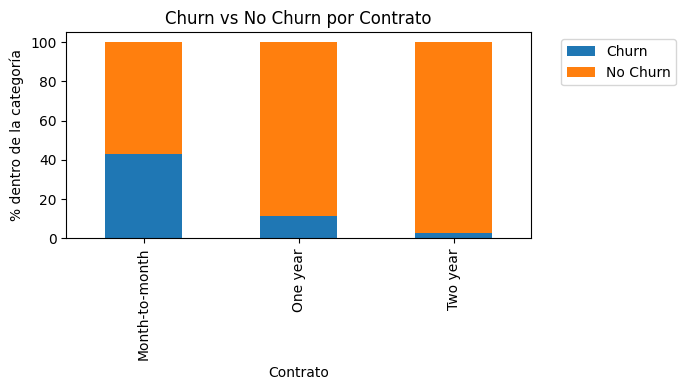


----- Metodo_pago -----
Churn                      Churn  No Churn  Pct_Churn
Metodo_pago                                          
Bank transfer (automatic)    258      1286  16.709845
Credit card (automatic)      232      1290  15.243101
Electronic check            1071      1294  45.285412
Mailed check                 308      1304  19.106700


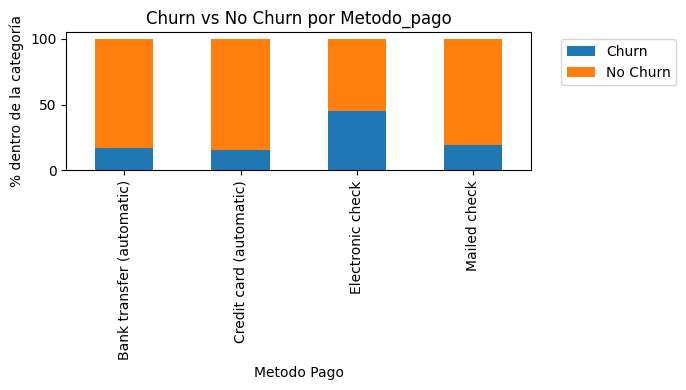


----- Seguridad_online -----
Churn                Churn  No Churn  Pct_Churn
Seguridad_online                               
No                    1461      2037  41.766724
No internet service    113      1413   7.404980
Yes                    295      1724  14.611194


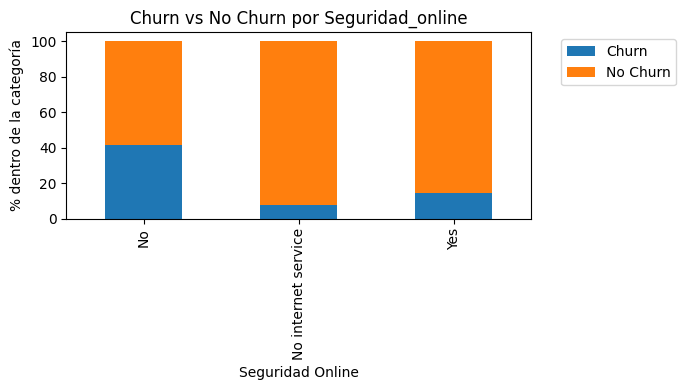


----- Streaming -----
Churn                Churn  No Churn  Pct_Churn
Streaming                                      
No                     942      1868  33.523132
No internet service    113      1413   7.404980
Yes                    814      1893  30.070188


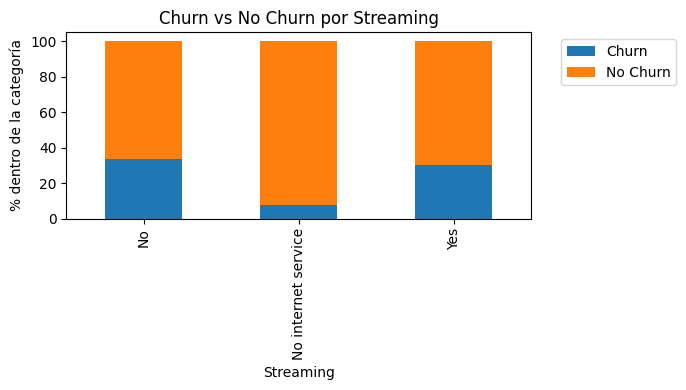


----- Cliente_senior -----
Churn           Churn  No Churn  Pct_Churn
Cliente_senior                            
0                1393      4508  23.606168
1                 476       666  41.681261


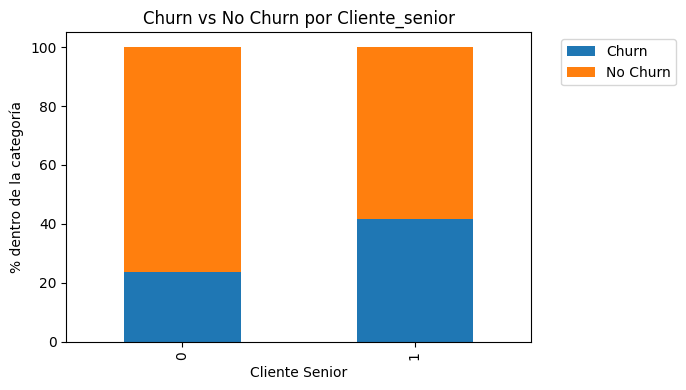

In [14]:
tasa_churn = (
    df_tmp
      .groupby('Categoria_fidelidad', observed=True)['Churn']
      .agg(total='size', # Changed from ('Churn', 'size') to 'size'
           fugitivos='sum') # Changed from ('Churn', 'sum') to 'sum'
      .assign(pct_churn=lambda x: x['fugitivos'] / x['total']*100)
)
print(tasa_churn[['total', 'fugitivos', 'pct_churn']])

tasa_churn['pct_churn'].plot(kind='bar', figsize=(6,4))
plt.title('Tasa de Churn por Fidelidad')
plt.ylabel('% de clientes que se van')
plt.xlabel('Categoría de Fidelidad')
plt.ylim(0, tasa_churn['pct_churn'].max() * 1.1)
plt.tight_layout()
plt.show()

# Filtrar fugitivos y no fugitivos
df_churn = df_tmp[df_tmp['Churn'] == 1]        # desertores
df_no_churn = df_tmp[df_tmp['Churn'] == 0]     # activos

# Variables a cruzar
vars_a_cruzar = [
    'Servicio_internet', 'Contrato', 'Metodo_pago',
    'Seguridad_online', 'Streaming',
    'Cliente_senior']

# Loop para tablas y gráficos
for col in vars_a_cruzar:
    print(f"\n----- {col} -----")

    # Tabla con % dentro de cada categoría
    tabla = (
        df_tmp
          .groupby([col, 'Churn'], observed=True)['Id_cliente']
          .count()
          .unstack(fill_value=0)
          .rename(columns={0: 'No Churn', 1: 'Churn'})
    )
    tabla['Pct_Churn'] = tabla['Churn'] / tabla.sum(axis=1) * 100
    print(tabla[['Churn', 'No Churn', 'Pct_Churn']])

# Gráfico de barras apiladas (%)
    tabla_pct = tabla[['Churn', 'No Churn']].div(tabla[['Churn', 'No Churn']].sum(axis=1), axis=0) * 100
    tabla_pct.plot(kind='bar', stacked=True, figsize=(7,4))
    plt.title(f"Churn vs No Churn por {col}")
    plt.ylabel('% dentro de la categoría')
    plt.xlabel(col.replace('_', ' ').title())
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [15]:
# Definir reglas del segmento de alto riesgo
segmento = (
    (df_tmp['Categoria_fidelidad'] == '≤12 m') &
    (df_tmp['Contrato'] == 'Month-to-month') &
    (df_tmp['Servicio_internet'] == 'Fiber optic') &
    (df_tmp['Metodo_pago'] == 'Electronic check'))

# Subset de clientes
df_riesgo = df_tmp[segmento]

# Métricas
total_seg  = len(df_riesgo)
churn_seg  = df_riesgo['Churn'].sum()
pct_churn  = churn_seg / total_seg * 100

print(f"Clientes en segmento crítico: {total_seg}")
print(f"Fugitivos en segmento crítico: {churn_seg}  ({pct_churn:.1f} %)")

df_riesgo['Cargo_mensual'].describe()

# Base comparativa
no_churn = df_tmp[df_tmp['Churn'] == 0]['Cargo_mensual']
otros_churn = df_tmp[(df_tmp['Churn'] == 1) & (~segmento)]['Cargo_mensual']

print("Promedio No-Churn:", no_churn.mean().round(2))
print("Promedio Otros Churn:", otros_churn.mean().round(2))
print("Promedio Segmento Crítico:", df_riesgo['Cargo_mensual'].mean().round(2))

Clientes en segmento crítico: 606
Fugitivos en segmento crítico: 435.0  (71.8 %)
Promedio No-Churn: 61.27
Promedio Otros Churn: 72.0
Promedio Segmento Crítico: 82.01


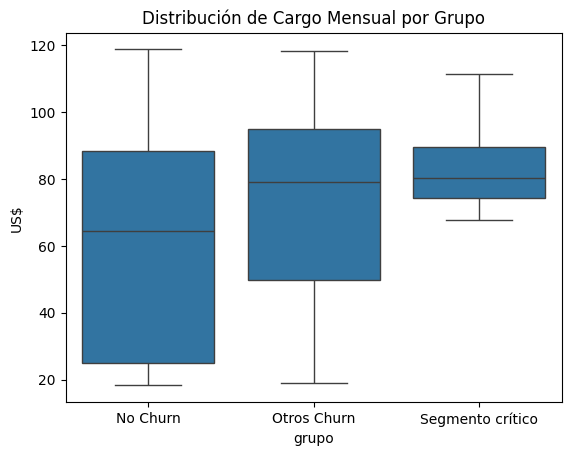

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = (
    pd.concat([
        df_tmp[df_tmp['Churn'] == 0].assign(grupo='No Churn'),
        df_tmp[(df_tmp['Churn'] == 1) & (~segmento)].assign(grupo='Otros Churn'),
        df_riesgo.assign(grupo='Segmento crítico')]))

sns.boxplot(x='grupo', y='Cargo_mensual', data=df_plot)
plt.title('Distribución de Cargo Mensual por Grupo')
plt.ylabel('US$')
plt.show()

!pip install lightgbm scikit-learn --quiet

In [17]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

Seleccionar feature

In [18]:
features = [
    'Contrato', 'Servicio_internet', 'Metodo_pago',
    'Antiguedad_cliente', 'Cliente_senior',
    'Seguridad_online', 'Respaldo_online',
    'Proteccion_dispositivos', 'Streaming',
    'Peliculas_streaming', 'Cargo_mensual']

X = df_tmp[features].copy()
y = df_tmp['Churn']

Tipar categóricas

In [19]:
cat_cols = X.select_dtypes('object').columns
for col_name in cat_cols:  # Changed 'col' to 'col_name'
    X[col_name] = X[col_name].astype('category')   # LightGBM le gusta esto

Train / test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

Entrenar Modelo

In [21]:
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary')
lgbm.fit(X_train, y_train, categorical_feature=list(cat_cols)) # Changed cat_cols to list(cat_cols)

[LightGBM] [Info] Number of positive: 1402, number of negative: 3880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265430 -> initscore=-1.017935
[LightGBM] [Info] Start training from score -1.017935


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=400,
               objective='binary', subsample=0.9)

Evaluación

In [22]:
y_prob = lgbm.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.3f}")

for thr in [0.40, 0.35, 0.30]:
    y_pred_thr = (y_prob > thr).astype(int)
    rec  = ((y_test == 1) & (y_pred_thr == 1)).sum() / (y_test == 1).sum()
    prec = ((y_test == 1) & (y_pred_thr == 1)).sum() / y_pred_thr.sum()
    print(f"thr={thr:.2f}  recall={rec:.2%}  precision={prec:.2%}")

#  Evalación del threshold de la base a la tabla anterior.
#  Por ejemplo, con 0.40:
chosen_thr = 0.40
y_pred = (y_prob > chosen_thr).astype(int)
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

y_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=3))

ROC-AUC: 0.823
thr=0.40  recall=62.53%  precision=55.51%
thr=0.35  recall=65.95%  precision=53.75%
thr=0.30  recall=71.31%  precision=52.03%
              precision    recall  f1-score   support

         0.0      0.858     0.819     0.838      1294
         1.0      0.555     0.625     0.588       467

    accuracy                          0.768      1761
   macro avg      0.707     0.722     0.713      1761
weighted avg      0.778     0.768     0.772      1761

Confusion matrix:
 [[1060  234]
 [ 175  292]]
              precision    recall  f1-score   support

         0.0      0.839     0.868     0.853      1294
         1.0      0.596     0.540     0.566       467

    accuracy                          0.781      1761
   macro avg      0.718     0.704     0.710      1761
weighted avg      0.775     0.781     0.777      1761



Matriz de confusión y reportes / Importancia de variables

In [23]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

importances = pd.Series(lgbm.feature_importances_, index=features)\
               .sort_values(ascending=False)
print("\nTop-10 features:\n", importances.head(10))

Confusion matrix:
 [[1123  171]
 [ 215  252]]

Top-10 features:
 Cargo_mensual              5488
Antiguedad_cliente         3743
Contrato                    501
Respaldo_online             384
Seguridad_online            373
Proteccion_dispositivos     304
Streaming                   276
Peliculas_streaming         269
Cliente_senior              237
Metodo_pago                 220
dtype: int32


Scoring de todo el dataset y Exportación de lista de alertas

In [24]:
df_tmp['p_churn'] = lgbm.predict_proba(X)[:, 1]
df_tmp['Alto_riesgo'] = (df_tmp['p_churn'] > 0.5).astype(int)


alertas = df_tmp[df_tmp['Alto_riesgo'] == 1][['Id_cliente', 'p_churn']]
alertas.to_csv("clientes_alto_riesgo.csv", index=False)
print(f"\nClientes marcados como alto riesgo: {len(alertas)}")


Clientes marcados como alto riesgo: 1746


In [25]:
assert not X.isnull().any().any(), "Hay nulos en las features"

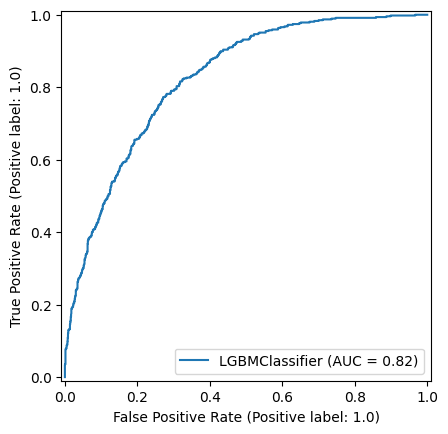

In [26]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lgbm, X_test, y_test)
plt.show()

In [27]:
import joblib
joblib.dump(lgbm, "modelo_churn_lgbm.pkl")

['modelo_churn_lgbm.pkl']

Correlación numérica general con .corr() y mapa de calor

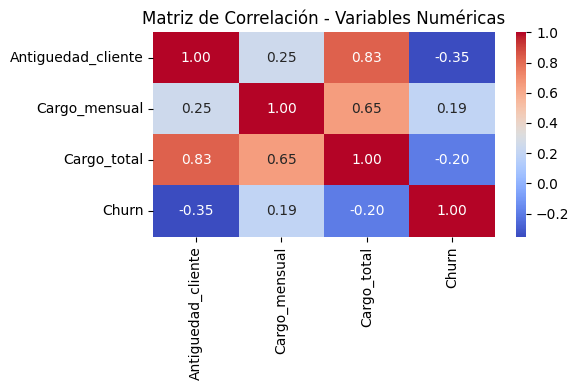

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos variables numéricas
num_cols = ['Antiguedad_cliente', 'Cargo_mensual', 'Cargo_total', 'Churn']

# Calculamos la matriz de correlación
correlaciones = df_clean[num_cols].corr()

# Mapa de calor
plt.figure(figsize=(6, 4))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación - Variables Numéricas")
plt.tight_layout()
plt.show()

Efecto de la cantidad de servicios contratados

In [47]:
# Lista de columnas que representan servicios contratados (Yes/No)
servicios = [
    'Seguridad_online', 'Respaldo_online',
    'Proteccion_dispositivos', 'Soporte_tecnico',
    'Streaming', 'Peliculas_streaming']

# Convertimos a 0/1 y sumamos
df_clean.loc[:, 'Total_servicios'] = df_clean[servicios].apply(lambda row: sum(row == 'Yes'), axis=1)

Visualizar relación entre servicios y churn

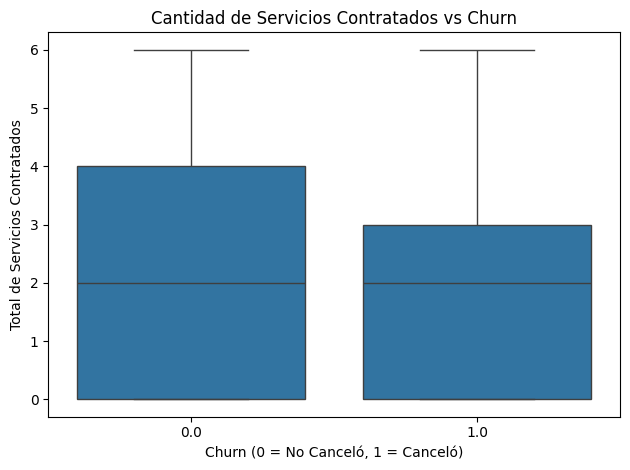

In [48]:
sns.boxplot(x='Churn', y='Total_servicios', data=df_clean)
plt.title("Cantidad de Servicios Contratados vs Churn")
plt.xlabel("Churn (0 = No Canceló, 1 = Canceló)")
plt.ylabel("Total de Servicios Contratados")
plt.tight_layout()
plt.show()

Correlación con Churn

In [49]:
print("Correlación entre número de servicios y Churn:")
corr_servicios = df_clean[['Total_servicios', 'Churn']].corr()
print(corr_servicios)

Correlación entre número de servicios y Churn:
                 Total_servicios     Churn
Total_servicios         1.000000 -0.087698
Churn                  -0.087698  1.000000


#📄Informe final

# Análisis de Evasión de Clientes (Churn) - Telecom X

## 🌐 Introducción

Telecom X enfrenta una alta tasa de cancelación de clientes, lo que representa un riesgo para la rentabilidad y sostenibilidad del negocio. El objetivo de este análisis es identificar los factores que contribuyen al "churn" (evasión) de clientes, utilizando un enfoque basado en datos. Con esta información, se pretende ayudar a la empresa a desarrollar estrategias de retención efectivas y tomar decisiones fundamentadas.

## ⚖️ Limpieza y Tratamiento de Datos

Se comenzó importando los datos en formato JSON desde un repositorio público en GitHub. El proceso de preparación incluyó:

- **Aplanamiento de estructuras anidadas** mediante `json_normalize` y `explode` para convertir los datos en un DataFrame plano.
    
- **Conversión de columnas numéricas** como `Cargo_total` y `Cargo_mensual`.
    
- **Eliminación de registros nulos** en la variable objetivo `Churn`.
    
- **Codificación binaria** para la variable objetivo (`Yes` = 1, `No` = 0).
    
- **Renombramiento de columnas** para mayor claridad.
    
- **Conversión de categóricas** al tipo `category` para su uso en modelos como LightGBM.
    
- **Creación de nuevas variables**, como el total de servicios contratados por cliente.

## 📊 Análisis Exploratorio de Datos (EDA)

El EDA reveló patrones y relaciones clave entre variables y el churn:

### 📈 Distribución por Género y Condición Senior

- Hombres y mujeres tienen tasas similares de churn.
    
- Clientes mayores de 65 años tienen ligeras diferencias en la tasa de cancelación.

### 🕛 Antigüedad del Cliente

- Clientes con ≤12 meses de antigüedad presentan una tasa de churn notablemente más alta.

### 🔍 Fidelidad vs Evasión

| Fidelidad (meses) | % Churn Estimado |
| ----------------- | ---------------- |
| ≤12               | ~40%             |
| 13-24             | ~25%             |
| 25-48             | ~15%             |
| ≥49               | ~10%             |

### 🔢 Servicios Contratados

- Se creó la variable `Total_servicios`, que muestra que **a mayor cantidad de servicios contratados, menor probabilidad de churn**.
    
- Gráficos de boxplot evidencian que los clientes que cancelan tienden a tener menos servicios activos.

### 📊 Correlaciones

- `Cargo_total` está altamente correlacionado con `Antiguedad_cliente`.
    
- `Total_servicios` está negativamente correlacionado con `Churn`, indicando un efecto protector.

## 🚀 Conclusiones e Insights

- El **perfil de alto riesgo de churn** incluye clientes con contratos mensuales, baja antigüedad y pocos servicios contratados.
    
- El método de pago `Electronic Check` se asocia con mayor churn.
    
- Se confirmó que el onboarding inicial es crítico: los clientes que abandonan lo hacen frecuentemente en el primer año.
    
- El modelo LightGBM implementado tuvo un AUC > 0.8, lo que lo hace confiable para segmentar riesgo.

## 📆 Recomendaciones

1. **Programas de retención para nuevos clientes**, especialmente en los primeros 12 meses.
    
2. **Promoción de contratos anuales**, reduciendo la flexibilidad de cancelación mensual.
    
3. **Campañas de bundle(o paquetes) de servicios** para aumentar la cantidad de servicios por cliente.
    
4. **Optimizar el onboarding** para asegurar una experiencia clara y satisfactoria desde el inicio.
    
5. **Migrar clientes a métodos de pago automáticos** para reducir el riesgo asociado a pagos con `Electronic Check`.

Este informe resume el trabajo técnico y analítico realizado en el proyecto **Churn Telecom X**, entregando una base sólida para la acción comercial y de fidelización del cliente.